<a href="https://colab.research.google.com/github/jayysinn98/Shill-Bidding-Detection/blob/main/ShillBidding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Exploratory Data Analysis

## 1.1 Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import scipy
from sklearn import metrics
import plotly
import plotly.io as pio
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
! pip install kneed
! pip install -U yellowbrick
from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from google.colab import files
pio.renderers.default = 'colab' 

     |████████████████████████████████| 274 kB 7.2 MB/s 


In [2]:
url='https://drive.google.com/file/d/1-AYeW6N-wxGw4y_yeGcoLmfwjxp6qN5T/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2] 
data = pd.read_csv(path)
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record_ID               6321 non-null   int64  
 1   Auction_ID              6321 non-null   int64  
 2   Bidder_ID               6321 non-null   object 
 3   Bidder_Tendency         6321 non-null   float64
 4   Bidding_Ratio           6321 non-null   float64
 5   Successive_Outbidding   6321 non-null   float64
 6   Last_Bidding            6321 non-null   float64
 7   Auction_Bids            6321 non-null   float64
 8   Starting_Price_Average  6321 non-null   float64
 9   Early_Bidding           6321 non-null   float64
 10  Winning_Ratio           6321 non-null   float64
 11  Auction_Duration        6321 non-null   int64  
 12  Class                   6321 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


(6321, 13)


Overall observation: There are 6321 observations of 13 attributes, all are numerical. There is no missing data, so there is no need to remove Nan or interpolate. 

In [3]:
data.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [4]:
data1 = data.drop(['Record_ID', 'Auction_ID', 'Bidder_ID'], axis=1) #removing ID variables 
data1.head()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


Class as pie chart:


Text(0, 0.5, '')

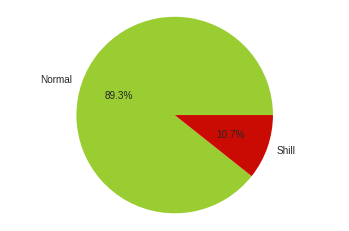

In [5]:
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(data1.Class.value_counts(),autopct='%1.1f%%', labels=['Normal','Shill'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

In the whole dataset, 10.7 % of the bidders are fraudulent bidders.

## 1.2 Data Exploration

In [6]:
df_class1 = data1[data1["Class"] == 1]
df_class2 = data1[data1["Class"] == 0]
count = max(df_class1.count()[0], df_class2.count()[0])
df_class1 = resample(df_class1, replace = df_class1.count()[0] < count, n_samples=count, random_state=0)
df_class2 = resample(df_class2, replace = df_class2.count()[0] < count, n_samples=count, random_state=0)
data1 = pd.concat([df_class1, df_class2])
print(data1.columns)
print(len(data1.index))

Index(['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding',
       'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average',
       'Early_Bidding', 'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')
11292


Histograms of attributes

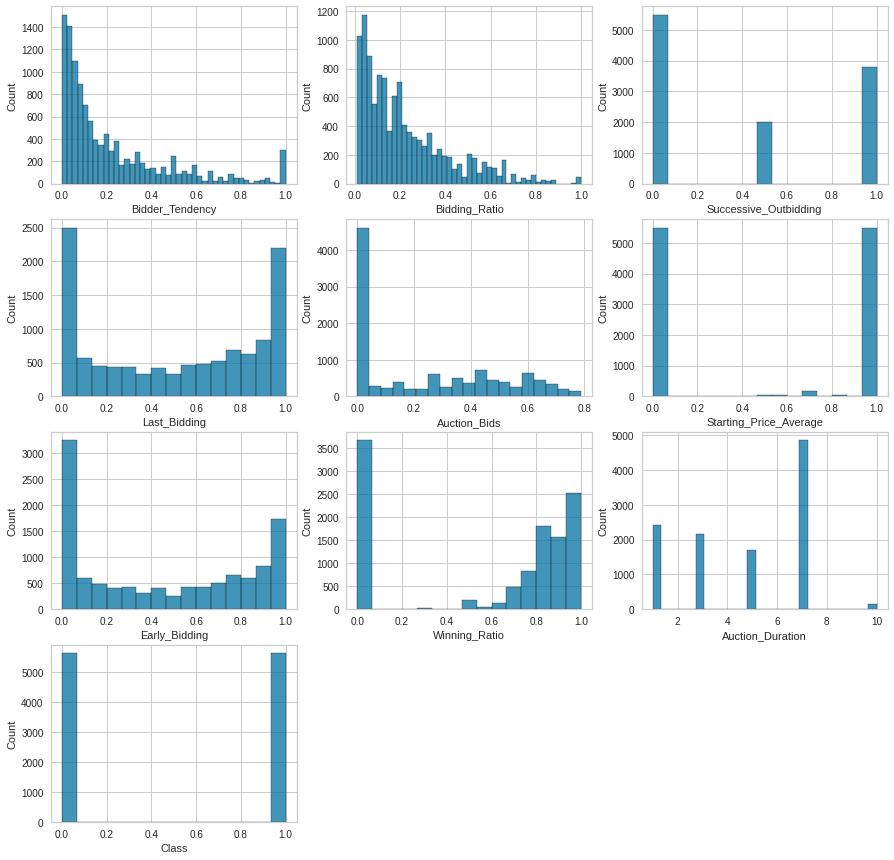

In [7]:
plt.figure(figsize=(15,15))
i = 0

cols = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio', 'Auction_Duration', 'Class']
for col in cols:
  i = i + 1
  plt.subplot(4,3,i)
  sns.histplot(data=data1[col], legend=True)

plt.show()


Correlation Matrix of all attributes

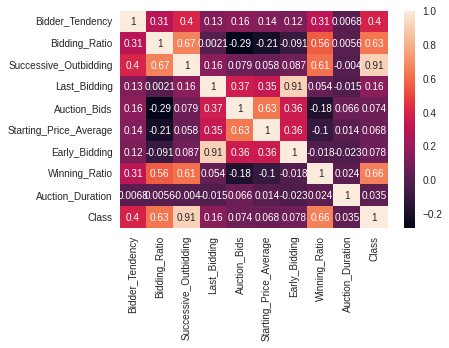

In [8]:
corrMatrix = data1.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Pairwise correlation

In [ ]:
plt.figure(figsize=(25,20))
sns.pairplot(data1, hue='Class')
plt.show()

Observation: 
No pair of two variables can separate the two class (0 & 1).

Bidder Tendency, Bidding Ratio and Successive Outbidding show that the smaller values of these three attributes represent more normal bidding behaviours.



Next, for each attribute, we create histograms for the normal and shill bidders to identify potentially important variables for our analysis

Bidder Tendency


Text(0, 0.5, 'Bids')

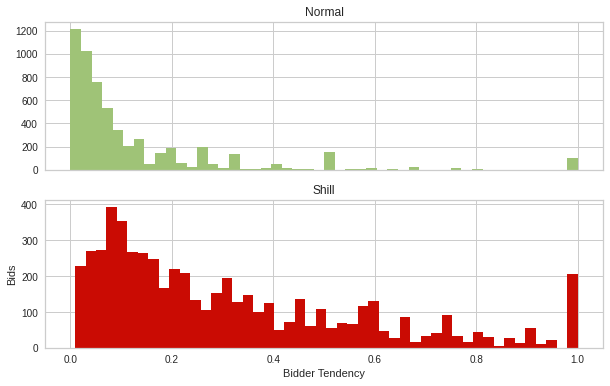

In [10]:
print("Bidder Tendency")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Bidder_Tendency[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Bidder_Tendency[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Bidder Tendency')
plt.ylabel('Bids')

It can be observed that normal bidder tendency ranges from 0 to 0.2


while a shill bidder's bidder tendency ranges 0 to 1

Bidding Ratio


Text(0, 0.5, 'Bids')

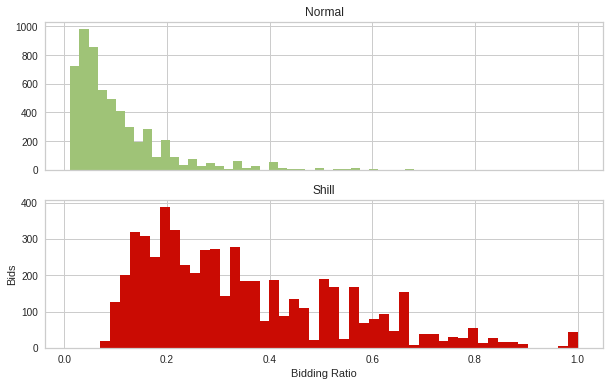

In [11]:
print("Bidding Ratio")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Bidding_Ratio[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Bidding_Ratio[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Bidding Ratio')
plt.ylabel('Bids')

It can be observed that normal bidders' bidding ratios largely range from 0 to 0.2 while shill bidders' bidding ratios are mostly in the range from 0.1 to 0.8.

Successive Outbidding


Text(0, 0.5, 'Bids')

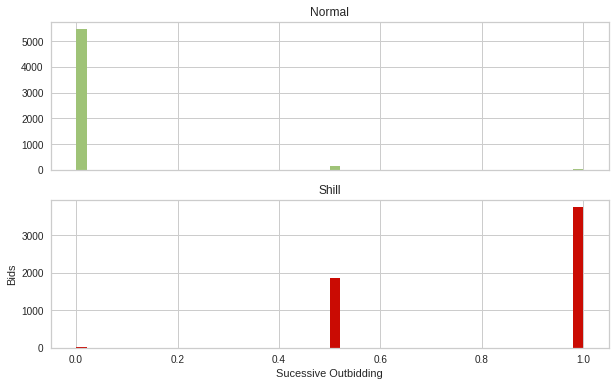

In [12]:
print("Successive Outbidding")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Successive_Outbidding[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Successive_Outbidding[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Sucessive Outbidding')
plt.ylabel('Bids')

It can be observed that a shill bidder has successive outbidding value of 0.5 
or 1.0, whereas a normal bidder always has 0 for successive outbidding.


Last bidding


Text(0, 0.5, 'Bids')

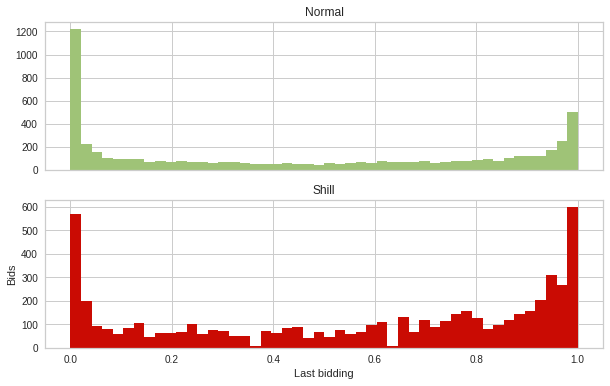

In [13]:
print("Last bidding")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Last_Bidding[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Last_Bidding[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Last bidding')
plt.ylabel('Bids')

The distribution for last bidding is similar for both normal and shill bidders. 

Auction_Bids


Text(0, 0.5, 'Bids')

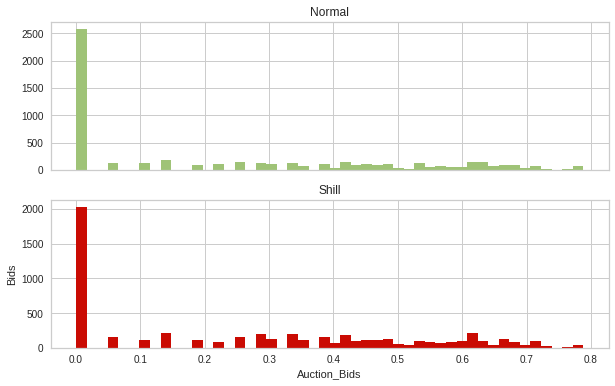

In [14]:
print("Auction_Bids")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Auction_Bids[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Auction_Bids[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Auction_Bids')
plt.ylabel('Bids')

The distribution for auction bids is similar for both normal and shill bidders. 

Auction Starting Price


Text(0, 0.5, 'Bids')

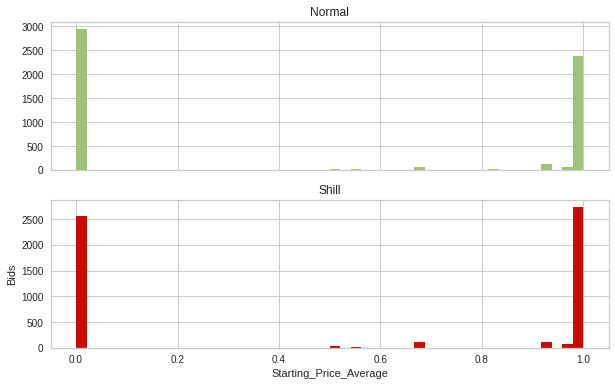

In [15]:
print("Auction Starting Price")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Starting_Price_Average[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Starting_Price_Average[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Starting_Price_Average')
plt.ylabel('Bids')

The distribution for auction starting price average is similar for both normal and shill bidders. 

Early Bidding


Text(0, 0.5, 'Bids')

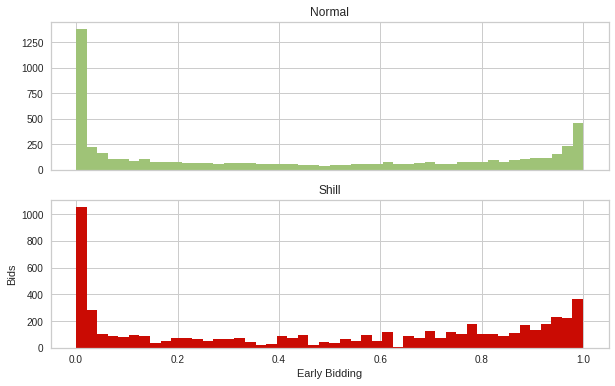

In [16]:
print("Early Bidding")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Early_Bidding[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Early_Bidding[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Early Bidding')
plt.ylabel('Bids')

The distribution for early bidding is similar for both normal and shill bidders. 

Winning_Ratio


Text(0, 0.5, 'Bids')

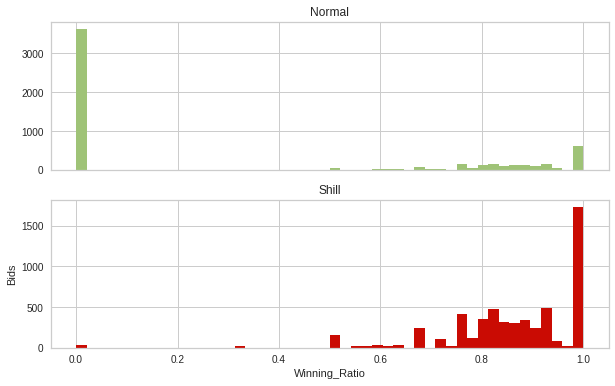

In [17]:
print("Winning_Ratio")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Winning_Ratio[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Winning_Ratio[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Winning_Ratio')
plt.ylabel('Bids')

It can be observed that normal bidders mostly have winning ratio value 0 whereas most shill bidders have winning ratio ranging from 0.7 to 1.

Auction_Duration


Text(0, 0.5, 'Bids')

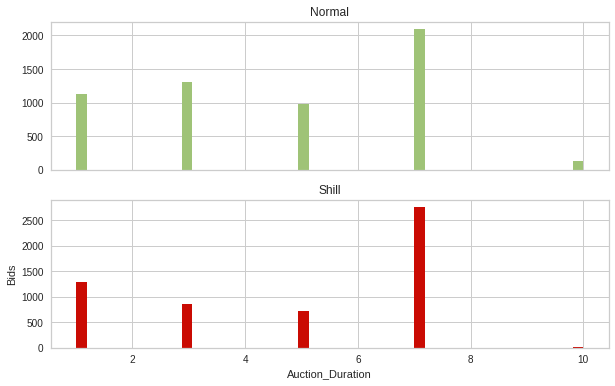

In [18]:
print("Auction_Duration")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
ax1.hist(data1.Auction_Duration[data1.Class==0],bins=48,color='g')
ax1.set_title('Normal')
ax2.hist(data1.Auction_Duration[data1.Class==1],bins=48,color='r')
ax2.set_title('Shill')
plt.xlabel('Auction_Duration')
plt.ylabel('Bids')

The distribution for auction duration is similar for both normal and shill bidders. 

## 1.3 Insights from EDA

From the bar plots above, we could see that the variables: **Bidder Tendency, Bidding Ratio, Successive Outbidding, and Winning Ratio** are significantly different for the target variable class(0 and 1).

On the other hand, the distrubutions of other variables are largely similar for both class types(0 - normal bidding behaviour and 1 - shill bidding behaviour).

Since these observations corroborate the relationships illustrated in the earlier pairwise attribute plot, we keep only the attributes that are significantly different in distribution between normal and shill bidders. 

In [19]:
data_reduced = data[['Bidder_Tendency','Bidding_Ratio','Successive_Outbidding','Winning_Ratio','Class']]
data_reduced.head()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Winning_Ratio,Class
0,0.200000,0.400000,0.0,0.666667,0
1,0.024390,0.200000,0.0,0.944444,0
2,0.142857,0.200000,0.0,1.000000,0
3,0.100000,0.200000,0.0,1.000000,0
4,0.051282,0.222222,0.0,0.500000,0


# 2. Unsupervised Learning 

## 2.1 Determining the number of clusters




### Elbow method with Total WCSS vs Number of Clusters

In [20]:
data_array = data_reduced.to_numpy() #convert df to a numpy array for WCSS

#WCSS Scatterplot
wcss = []
max_k = 10 
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_array)
    wcss.append(kmeans.inertia_)

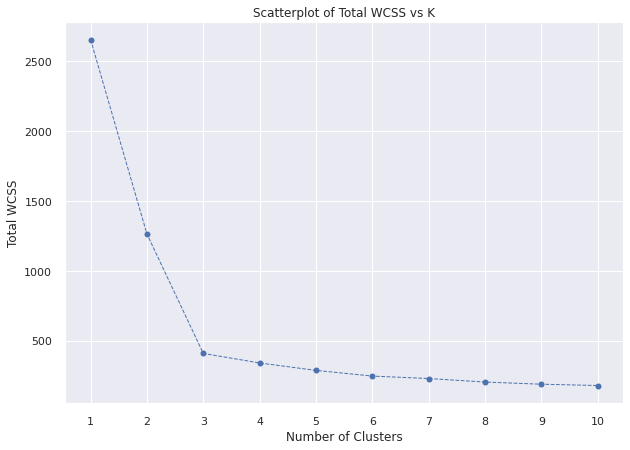

The number of Clusters should be 3


In [21]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")
print('The number of Clusters should be {}'.format(kl.elbow))

### Comparing Silhouette Width

In [22]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_array)
    score = silhouette_score(data_array, kmeans.labels_,metric = 'euclidean') #calculate silhouette score for that k
    silhouette_coefficients.append(score) #append it to the coefficients array

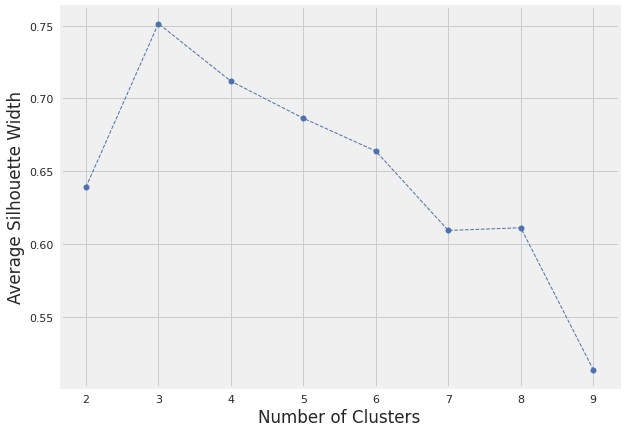

In [23]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

From the Silhouette Width plot, it is clear that 3 clusters will return the highest Silhouette Width.

So we will have 3 clusters for this dataset.

## 2.2 Dimension Reduction for clustering visualization




We use the t-SNE method to reduce the dimension, for the purpose of visualization.

In [24]:
from sklearn.manifold import TSNE
data_unlabelled = data_reduced.drop(['Class'], axis = 1) #remove class label

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



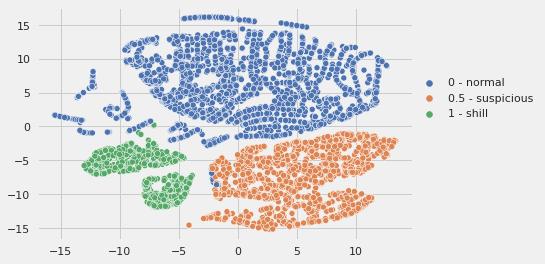

In [25]:
y_tsne = TSNE(n_components=2, perplexity = 40, n_iter = 300, random_state=42).fit_transform(data_unlabelled) #target dimension is 2
y1_kmeans = KMeans(n_clusters=3, random_state=42).fit_predict(data_unlabelled)
g = sns.scatterplot(x=y_tsne[:,0], y=y_tsne[:,1], hue=y1_kmeans, palette="deep")

handles, labels  =  g.get_legend_handles_labels()
g.legend(handles, ['0 - normal', '0.5 - suspicious', '1 - shill'], loc = (1.0, 0.5))

Checking the centre values of the attributes in each cluster

In [26]:
kmeans_test = KMeans(init="random",n_clusters =3, random_state = 42)
kmeans_test.fit(data_unlabelled)
clustergroups = kmeans_test.labels_ #The cluster number for each row

In [27]:
Clustercenters = pd.DataFrame(kmeans_test.cluster_centers_) #Dataframe of cluster centers
Clustercenters.rename(columns={0: "Bidder Tendency", 1: "Bidding Ratio", 2: "Successive Outbidding", 3: "Winning Ratio"},inplace=True)
Clustercenters.index.name = "Clusters"
Clustercenters

,Bidder Tendency,Bidding Ratio,Successive Outbidding,Winning Ratio
Clusters,,,,
0,0.298212,0.337344,7.964602e-01,0.852783
1,0.107860,0.052215,7.148749e-03,0.001026
2,0.144125,0.185027,-1.124101e-15,0.869595


Since the data is already scaled such that 0 and 1 are likely to be values observed for normal and shill bidders respectively, cluster numbers 0 and 2 should naturally be these 2 labels, with cluster number 1 being an in-between between the 2 types of bidders.

## 2.3 Re-labelling the data according to new number of clusters

We assign 3 labels : **normal** and **shill** bidders as per the original labels, with the addition of a **'suspicious'** label, for cases whereby the bidder cannot be confirmed as a shill bidder, but exhibits some degree of suspicious behaviour.

Since the values of the attributes have been calculated in a way such that values close to 0 are behaviours of a normal bidder and vice versa, discretizing the data will simply be done using the mean of each of the attributes. For each instance, any attributes with values greater than mean amount to a score of +1, and 0 otherwise.


In [28]:
data_reduced.head()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Winning_Ratio,Class
0,0.200000,0.400000,0.0,0.666667,0
1,0.024390,0.200000,0.0,0.944444,0
2,0.142857,0.200000,0.0,1.000000,0
3,0.100000,0.200000,0.0,1.000000,0
4,0.051282,0.222222,0.0,0.500000,0


First, we define a function to discretize and subsequently calculate the suspicion scores for the data.

In [29]:
def discretize_score_data(data):
    #first discretize according to mean
    data_discrete = np.zeros_like(data) # initialize array of 0s

    D = data_discrete.shape[1]
    print(D)
    for i in range(D):
        mean_value = np.mean(data[:, i]) #get the mean
        data_discrete[:, i] = (data[:, i] > mean_value).astype(float) #see if value greater than mean, convert boolean to float
    
    #using the binary values given, create array of scores to replace the nested array

    scores_array = []
    L = len(data_discrete)
    for i in range(L) :
        scores_array.append(data_discrete[i].sum())

    return scores_array

Next, we create a dictionaries of the original labels and calculated scores to determine the threshold score for each label

In [30]:
og_labels = data_reduced['Class']
temp = data_reduced.drop(columns='Class')
scores = discretize_score_data(temp.to_numpy())
data_reduced['Score'] = pd.Series(scores, index = temp.index)

label_freq = {}
for label in og_labels.to_numpy():
  if (label in label_freq):
    label_freq[label] += 1 #if the label is in the dictionary already, add count
  else :
    label_freq[label] = 1 #if label is not in dictionary, add it and set count to 1

score_freq = {}
for score in scores :
  if (score in score_freq):
    score_freq[score] += 1
  else :
    score_freq[score] = 1

label_freq, score_freq

4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



({0: 5646, 1: 675}, {0.0: 2805, 1.0: 1280, 2.0: 1071, 3.0: 704, 4.0: 461})


There were 675 shill bidders from the initial dataset. To avoid wrong accusations of bidders, the number of bidders with the score for 'Shill Bidder' must be at most 675. Therefore, we set the threshold for the 'shill bidder' label to be the maximum score of 4.

Similarly, there was a total of 5156 (2805 + 1280 + 1071) bidders with scores less than or equal to 2, which is similar to the number of normal bidders, 5646.

Thus, we set the threshold for the 'suspicious bidder' label to be 3.

The classifications are as follows :

1.   Shill Bidder - Score of 4
2.   Suspicious Bidder - Score of 3
3.   Normal Bidder - Score of < 3

Measuring accuracy of the scores with respect to the new labels

get index of bidders with score = 4 (predicted shill)
get index of bidders with class = 1 (actual shill)
^ equate both and find number of TRUE labels / 675 (total num of shill bidders) *100

In [31]:
pred_shill = data_reduced.index[data_reduced['Score'] == 4].tolist() #index of predicted shill
actual_shill = data_reduced.index[data_reduced['Class'] == 1].tolist()
pred_shill_as_set = set(pred_shill)
intersection = pred_shill_as_set.intersection(actual_shill)
len(intersection) / 675

0.6014814814814815

In [32]:
actual1 = len(data_reduced[(data_reduced['Score'] == 4)]) #TP + FP
predicted1 = len(data_reduced[(data_reduced['Score'] == 4) & (data_reduced['Class'] == 1)]) #TP
pct1 = predicted1 / actual1 * 100 
print('Percentage of bidders with Score = 4 who are shill bidders : {}%'.format(round(pct1,1)))

Percentage of bidders with Score = 4 who are shill bidders : 88.1%


In [33]:
actual0 = len(data_reduced[(data_reduced['Score'] < 3)]) #TN + FN
predicted0 = len(data_reduced[(data_reduced['Score'] < 3) & (data_reduced['Class'] == 0)]) #TN
pct0 = predicted0 / actual0 * 100
print('Percentage of bidders with Score < 3 who are normal bidders : {}%'.format(round(pct0,1)))

Percentage of bidders with Score < 3 who are normal bidders : 99.6%


In [34]:
(predicted0 + predicted1) / (actual0 + actual1)

0.9868257076731352

Labelling of the normal and shill bidders looks good with the threshold of 3.

What about the suspicious bidders?

In [35]:
sus0 = len(data_reduced[(data_reduced['Score'] == 3) & (data_reduced['Class'] == 0)])
sus1 = len(data_reduced[(data_reduced['Score'] == 3) & (data_reduced['Class'] == 1)])
sus = score_freq[3]
print('Percentage of suspicious bidders who are shill : {}%'.format(round(sus1/sus*100,1)))
print('Percentage of suspicious bidders who are normal : {}%'.format(round(sus0/sus*100,1)))

Percentage of suspicious bidders who are shill : 35.5%
Percentage of suspicious bidders who are normal : 64.5%


With shill bidders still taking up a relatively large proportion of these suspicious bidders, our proposed solutions will therefore have to account for these suspicious bidders.

#### Relabelling Data

In [36]:
data_relabelled = data_reduced
data_relabelled.loc[data_relabelled['Score'] == 3.0, 'Class'] = '0.5'
data_relabelled.loc[data_relabelled['Score'] < 3.0, 'Class'] = '0'
data_relabelled.loc[data_relabelled['Score'] > 3.0, 'Class'] = '1'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
data_relabelled.head(10)

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Winning_Ratio,Class,Score
0,0.200000,0.400000,0.0,0.666667,0.5,3.0
1,0.024390,0.200000,0.0,0.944444,0,2.0
2,0.142857,0.200000,0.0,1.000000,0.5,3.0
3,0.100000,0.200000,0.0,1.000000,0,2.0
4,0.051282,0.222222,0.0,0.500000,0,2.0
5,0.038462,0.111111,0.0,0.800000,0,1.0
6,0.400000,0.222222,0.0,0.750000,0.5,3.0
7,0.137931,0.444444,1.0,1.000000,0.5,3.0
8,0.121951,0.185185,1.0,0.944444,0.5,3.0
9,0.155172,0.346154,0.5,0.611111,1,4.0


We have relabelled the bidders based on their score. Class 0 for normal bidders, class 0.5 for suspicious bidders and class 1 for shill bidders.

# 4. Supervised Learning

In [38]:
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve
pd.set_option("display.max_rows", None, "display.max_columns", None)
import math

In [39]:
# Creating a pipeline function for common classifier algorithms

## function to fit different classifier models

def get_predictions(clf, X_train, y_train, X_test): 
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred

## function to get confusion matrix
def get_cm(y_test,y_pred):
  cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  cm.columns = ['True Y=0', 'True Y=0.5', 'True Y=1']
  cm.index = ['Predicted Y=0',' Predicted Y=0.5', 'Predicted Y=1']
  return cm


## function to calculate auc score for multiclass
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict


## function to get classifiers score 
def get_scores(y_test, y_pred):
  #Calculate Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy: '+str(accuracy))

  # Calculate Sensitivity (true positive rate)
  sensitivity = recall_score(y_test, y_pred, average='macro')
  print('Sensitivity: '+str(sensitivity))
  
  #Precision
  precision = precision_score(y_test, y_pred, average='macro')
  print('Precision: '+str(precision))

  # AUC
  print('AUC:',roc_auc_score_multiclass(y_test,y_pred))

  #F1 Score
  print("F1 score:", round(f1_score(y_test, y_pred, average='macro'), 4))


## 3.1 Preparing training and testing data

In [40]:
y = data_relabelled['Class'].values #target
X = data_relabelled.drop(['Score', 'Class'],axis=1).values #features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## 3.2 Support Vector Machine

In [42]:
y_pred = get_predictions(SVC(kernel = 'linear', C = 1), X_train, y_train, X_test)

train-set confusion matrix:
 [[4064   56    7]
 [ 199  243  120]
 [   0   89  278]]


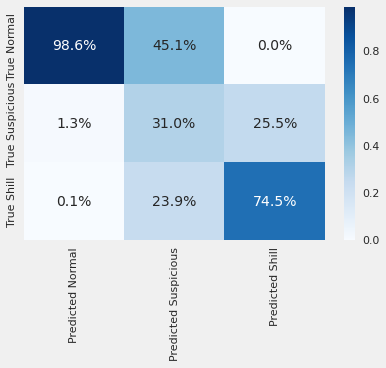

In [43]:
cm = get_cm(y_test, y_pred) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',xticklabels=["Predicted Normal", "Predicted Suspicious", "Predicted Shill"],
            yticklabels=["True Normal", "True Suspicious", "True Shill"])

In [44]:
get_scores(y_test,y_pred)

Accuracy: 0.892490118577075
Sensitivity: 0.6803115212721789
Precision: 0.7168541211379229
AUC: {'0': 0.8576040585725817, '0.5': 0.6384558463873177, '1': 0.8573959336446392}
F1 score: 0.687


## 3.3 Naive Bayes

In [45]:
y_pred = get_predictions(GaussianNB(), X_train, y_train, X_test)

train-set confusion matrix:
 [[3957  170    0]
 [ 157  302  103]
 [   0   91  276]]


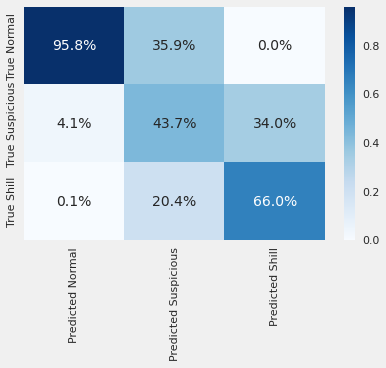

In [46]:
cm = get_cm(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',xticklabels=["Predicted Normal", "Predicted Suspicious", "Predicted Shill"],
            yticklabels=["True Normal", "True Suspicious", "True Shill"])

In [47]:
get_scores(y_test,y_pred)

Accuracy: 0.8774703557312253
Sensitivity: 0.6848020141886684
Precision: 0.6935383561835282
AUC: {'0': 0.8710550806278927, '0.5': 0.6853623969999875, '1': 0.8169776695677453}
F1 score: 0.6891


## 3.4 Multinomial Logistic Regression

In [48]:
y_pred = get_predictions(LogisticRegression(multi_class='multinomial'), X_train, y_train, X_test)

train-set confusion matrix:
 [[4067   58    2]
 [ 197  254  111]
 [   0   95  272]]


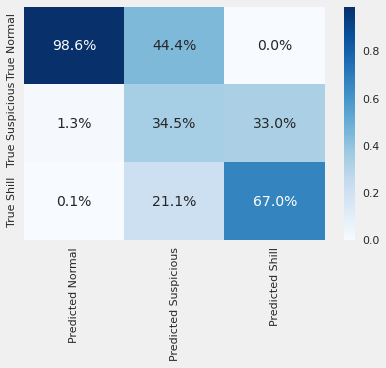

In [49]:
cm = get_cm(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',xticklabels=["Predicted Normal", "Predicted Suspicious", "Predicted Shill"],
            yticklabels=["True Normal", "True Suspicious", "True Shill"])

In [50]:
get_scores(y_test,y_pred)

Accuracy: 0.8909090909090909
Sensitivity: 0.6672259154385958
Precision: 0.712884309315332
AUC: {'0': 0.8597227026403782, '0.5': 0.652944828364667, '1': 0.821869833021422}
F1 score: 0.6836


## 3.5 Decision Tree

In [51]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [52]:
dt = DecisionTreeClassifier(max_depth=None).fit(X_train,y_train)
y_pred = get_predictions(DecisionTreeClassifier(max_depth=None), X_train, y_train, X_test)

train-set confusion matrix:
 [[4127    0    0]
 [   0  562    0]
 [   0    0  367]]


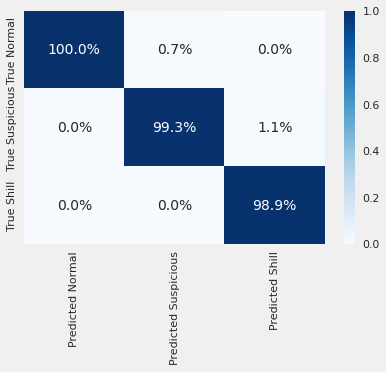

In [53]:
cm = get_cm(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',xticklabels=["Predicted Normal", "Predicted Suspicious", "Predicted Shill"],
            yticklabels=["True Normal", "True Suspicious", "True Shill"])

In [54]:
get_scores(y_test,y_pred)

Accuracy: 0.9984189723320158
Sensitivity: 0.9941064828688443
Precision: 0.9973289575641552
AUC: {'0': 0.9978813559322034, '0.5': 0.9960336372643699, '1': 0.9946808510638299}
F1 score: 0.9957


#### Visualizing the Decision Tree

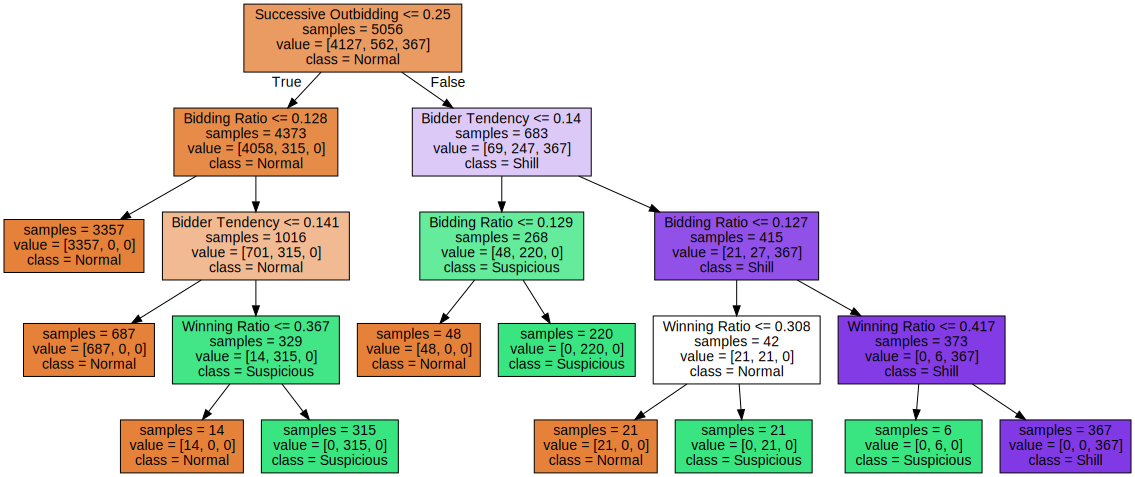

In [55]:
import graphviz
#export the decision tree to dot format
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=('Bidder Tendency','Bidding Ratio', 'Successive Outbidding','Winning Ratio',),  
                                class_names=('Normal','Suspicious','Shill'),
                                impurity = False,
                                filled=True)
#creating the plot
graph = graphviz.Source(dot_data, format="png") 
graph


In [56]:
y2 = data_relabelled['Class'] #target
X2 = data_relabelled.drop(['Score', 'Class'],axis=1) #features
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=42, stratify=y)


In [57]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [58]:
X_train = pd.DataFrame(X_train, columns = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Winning_Ratio'])
feature_imp(dt)

[('Bidder_Tendency', 0.395),
 ('Successive_Outbidding', 0.39),
 ('Bidding_Ratio', 0.177),
 ('Winning_Ratio', 0.037)]

<BarContainer object of 4 artists>

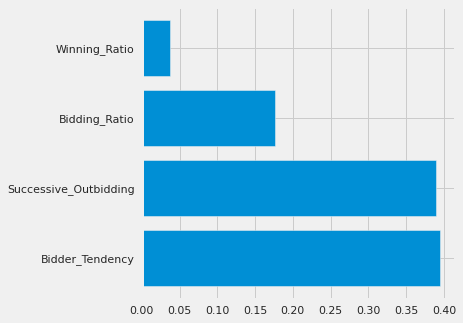

In [59]:
plt.figure(figsize=(5,5))
imp = feature_imp(dt)
x_val = [x[0] for x in imp]
y_val = [x[1] for x in imp]
plt.barh(x_val,y_val)

We observe that Successive Outbidding and Bidder Tendency have higher feature importance values, thus they are more significant than Winning Ratio and Bidding Ratio in the classification of bidders. 

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples.

Based on the confusion matrices and various evaluation metrics for Support Vector Machine, Naive Bayes and Decision Tree, we can conclude that Decision Tree is the most effective model for classifying bidders into normal, suspicious and shill. 